# Syntactic Processing Case Study

# Problem Statement

**BeHealthy**, a health tech company, connects medical professionals with millions of patients nationwide through its web platform. The platform enables doctors to list services, manage patient interactions, and facilitates patient services like online appointment booking and medicine orders. It streamlines appointment organization, allows tracking of medical records, and supports the issuance of e-prescriptions.

**BeHealthy** needs a **predictive model** to discern diseases and treatments based on patient interactions with doctors or online medicine orders.

**Objective:**
    
- The aim is to extract essential details from text, identifying relevant entities. This is crucial given the medical terminology used in conversations between healthcare professionals and patients, diverging from everyday language.
- Extract key insights from text while identifying relevant entities, driven by the specialized medical terminology used in conversations between healthcare professionals and patients, distinct from everyday language. 

**Methodology:**

In meeting the requirements, it's evident we must analyze text, identifying entities such as diseases and treatments. These needs can be anticipated through predictive methods.
  - CRF (Conditional Random Field) Classifier
  - Random Forest Classifier
  - HMM (Hidden Markov Model)

**Developing a CRF model with custom NER for Medical Entity Recognition, as the targeted entities pertain exclusively to medical terminologies.**

We are provided with four data files for this activity:

1. Train Sentence Dataset
2. Train Label Dataset
3. Test Sentence Dataset
4. Test Label Dataset

The **sentence file** encompasses patient-doctor interactions, while the **label file** contains entity tags aligned with specific words within each sentence. Further preprocessing steps will be undertaken during dataset access.

# Importing Required Libraries

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import re
import spacy

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

### Preprocessing Functions

In [3]:
#Extracting sentence from words:
def content_extract(file_path = '', sep = '\t'):
    '''It helps to extract the word based on the separator to form the sentence'''
    try:
        with open (file_path,'r', encoding = 'utf-8') as text:
            if text.mode  == 'r':
                content = text.readlines()
        sentence = []
        final_sentence=''
        for c in content:
            content_word = c.strip('\n')
            if content_word == '':
                #Upon matching with the separator, it appends the previously extracted concatenated string as a sentence
                #final_sentence = re.sub('(?<=[\(]) | (?=[%\',)])','', final_sentence)
                sentence.append(final_sentence.strip(' '))

                #Initialize for next sentence
                final_sentence=''
            else:
                # Till the loop identifies the separator it concatenates string
                final_sentence+=content_word+' '
        print('Total identified value: ', len(sentence),'\n')
        print('Sample display value:\n', sentence[:5])
        return sentence
    except FileNotFoundError:
        print('Check and provide proper file path')

### Postprocessing Functions

In [4]:
#Class for extracting sentence details from a dataframe:
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

### Feature Extraction

In [5]:
#Feature set:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['EOS'] = True

    return features

In [6]:
#Create a function to extract sentence features:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [7]:
#Create a function for sentence labeling:
def sent2labels(sent):
    return [label for token, postag, label in sent]

# EDA

### Pre-processing

The dataset is structured with one word per line. Let's grasp the data format outlined below:

- Each sentence, comprising x words, is presented as x consecutive lines, with a clear separation between sentences marked by empty lines.

- The labeling format for the data maintains consistency, following the structure outlined above for two consecutive sentences.

**Data pre-processing is essential to retrieve intact sentences along with their corresponding labels.**

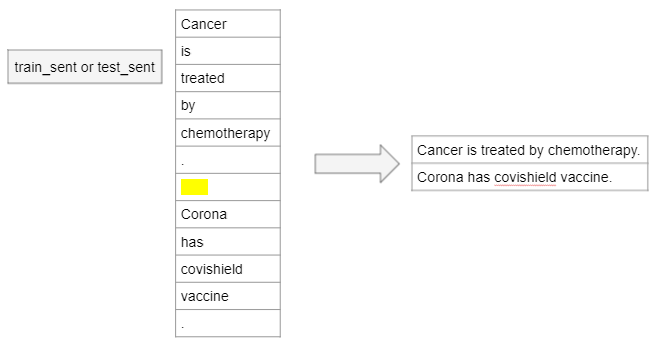

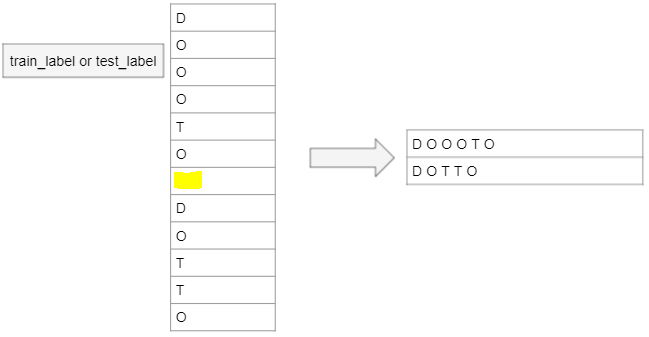

The dataset pertains to disease and treatment labels, denoted as **O, D** and **T**, representing **Other, Disease** and **Treatment**, respectively.

In [17]:
train_sentences = content_extract('train_sent')
train_labels = content_extract('train_label')
test_sentences = content_extract('test_sent')
test_labels = content_extract('test_label')

Total identified value:  2599 

Sample display value:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
Total identified value:  2599 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O 

### Extracting POS information using spaCy

In [21]:
#Importing the spaCy small library for medical entity recognition:
nlp_model = spacy.load("en_core_web_sm")

In [22]:
#Create a DataFrame for POS tagging, lemma words, and labels for both training and testing sentences:
train_df = pd.DataFrame(columns = ['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns = ['sentence','word','lemma','pos','label'])

In [26]:
#train datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(train_sentences, train_labels):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp_model(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [27]:
#test datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(test_sentences, test_labels):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp_model(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

### Word frequency for POS tags NOUN and PROPN

In [28]:
#Word frequency for terms categorized as NOUN or PROPN in POS tagging:
frequency_df = pd.DataFrame()
frequency_df = pd.concat((train_df,test_df), axis = 0)

In [29]:
#Reset the index:
frequency_df.reset_index(inplace=True,drop=True)

In [30]:
#Top 25 most frequent values in both the Train and Test datasets for words:
frequency_df[(frequency_df['pos'] == 'NOUN') | ((frequency_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: word, dtype: int64

In [31]:
#Top 25 lemma word frequencies for Train and Test datasets:
frequency_df[(frequency_df['pos'] == 'NOUN') | ((frequency_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: lemma, dtype: int64

### Visualize DataFrame (Sentence, Word, POS)

In [32]:
train_df.head()

,sentence,word,lemma,pos,label
0,1,All,all,PRON,O
1,1,live,live,VERB,O
2,1,births,birth,NOUN,O
3,1,>,>,PUNCT,O
4,1,or,or,CCONJ,O


In [33]:
test_df.head()

,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,SCONJ,O
3,1,all,all,PRON,O
4,1,deliveries,delivery,NOUN,O


### Prepare sentence-level detailed dataframe

In [34]:
#Retrieving detailed information for the training set:
train_sentence_obj = sentencedetail(train_df)
train_sentence_detail = train_sentence_obj.sentences

In [35]:
#Display a one-sentence detailed view of the training set:
train_sentence_detail[0]

[('All', 'PRON', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'VERB', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'PART', 'O'),
 ('reflect

In [36]:
#Retrieving detailed sentence information for the training set:
test_sentence_obj = sentencedetail(test_df)
test_sentence_detail = test_sentence_obj.sentences

In [37]:
#Display a concise, one-sentence overview of the training set details:
test_sentence_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'SCONJ', 'O'),
 ('all', 'PRON', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'VERB', 'O'),
 ('to', 'PART', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'PRON', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'VERB', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'VERB', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'NOUN', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('199

# Input and Target Variable

In [38]:
#Prepare X-train and X-test by extracting features from the training and testing datasets:
X_train = [sent2features(s) for s in train_sentence_detail]
X_test = [sent2features(s) for s in test_sentence_detail]

In [39]:
#Prepare y-train and y-test by extracting labels from the respective training and testing datasets:
y_train = [sent2labels(l) for l in train_sentence_detail]
y_test = [sent2labels(l) for l in test_sentence_detail]

# Building a CRF model with sklearn

In [50]:
!pip install sklearn-crfsuite

import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [51]:
from sklearn_crfsuite import CRF

In [61]:
#Building the CRF model:
#crf_model = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions = False)
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    #Fit the model:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

# Evaluate model (F1-score)

In [62]:
#Compute the F1 score on the test dataset:
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average = 'weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 91.26 % 


# Predict Disease and Treatment

In [63]:
#Extracting the predicted label from the model:
predicted_label = []
for i in y_pred:
    predicted_label.extend(i)

In [64]:
#Loading into test dataframe:
test_df['label_predicted'] = predicted_label

In [65]:
#Visualizing the top 5 data:
test_df.head()

,sentence,word,lemma,pos,label,label_predicted
0,1,Furthermore,furthermore,ADV,O,O
1,1,",",",",PUNCT,O,O
2,1,when,when,SCONJ,O,O
3,1,all,all,PRON,O,O
4,1,deliveries,delivery,NOUN,O,O


# Dictionary Preparation

In [66]:
#Creating a dictionary where diseases serve as unique keys and their corresponding treatments as values:
new_df = test_df[(test_df['label_predicted'] != 'O')]
new_df.set_index('sentence', inplace = True)
disease = []
treatment = []
sentence = []
med_dict = {}
for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'label_predicted'].unique()
        if len(val) == 2:
            disease_value = new_df[new_df['label_predicted'] == 'D'].loc[i,'word']
            treatment_value = new_df[new_df['label_predicted'] == 'T'].loc[i,'word']
            disease_single = disease_value if type(disease_value) == str else " ".join(disease_value)
            treatment_single = treatment_value if type(treatment_value) == str else " ".join(treatment_value)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

In [67]:
print(med_dict)

{'nonimmune hydrops fetalis': 'Trisomy', 'retinoblastoma': 'radiotherapy', 'epilepsy': 'Methylphenidate', 'unstable angina or non - Q - wave myocardial infarction': 'roxithromycin', 'coronary - artery disease': 'Antichlamydial antibiotics', 'cellulitis': 'G - CSF therapy intravenous antibiotic treatment', 'foot infection': 'G - CSF treatment', 'hemorrhagic stroke': 'double - bolus alteplase', 'cardiac disease': 'fenfluramine - phentermine', "early Parkinson 's disease": 'Ropinirole monotherapy', 'treating stress urinary incontinence': 'surgical procedures', 'female stress urinary incontinence': 'surgical treatment', 'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination', 'severe acquired hyperammonemia cancer': 'organ transplantation and chemotherapy', 'major pulmonary embolism': 'thrombolytic treatment', 'malignant pleural mesothelioma': 'radiotherapy , and chemotherapy', 'pulmonary symptoms': 'chemotherapy', 'non - o

In [68]:
#Forecast treatment using a dictionary:
d = []
disease = ''
test_sent = []
treatment = ''

input_sent = 'Rahul suffering from advanced rectal cancer'
m = spacy.load('en_core_web_sm')
doc = m(input_sent)
for i in doc:
    d.append((i.text,i.pos_,'D'))
test_sent.append(sent2features(d))
for i,tag in enumerate(crf.predict(test_sent)[0]):
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr
        if tr in med_dict:
            treatment += ''+med_dict.get(tr)
if len(treatment) == 0:
    treatment = 'None'
print('Identified Disease: ',disease)
print('Identified Treatment: ', treatment)

Identified Disease:  rectalcancer
Identified Treatment:  Matrix metalloproteinase inhibitors
